In [1]:
# Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.stats import t

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout

In [2]:
# Funciones
def OLS_regr(X, Y, **kwargs):
    """
    Realiza una regresión lineal por mínimos cuadrados ordinarios (OLS).

    Calcula los parámetros `a` y `b` de una recta ajustada `Y = aX + b`, junto con los errores estándar,
    el coeficiente de correlación de Pearson, y opcionalmente, las incertidumbres de los parámetros si se
    proporcionan errores en las variables `X` e `Y`.

    Parameters
    ----------
    X : array_like
        Vector de valores independientes.
    Y : array_like
        Vector de valores dependientes.
    **kwargs : dict, opcional
        Argumentos opcionales que permiten incluir incertidumbres en los datos:

        - 'Delta_X' : array_like
            Errores estándar asociados a cada valor de `X`.
        - 'Delta_Y' : array_like
            Errores estándar asociados a cada valor de `Y`.

    Returns
    -------
    a : float
        Pendiente de la recta ajustada.
    b : float
        Ordenada al origen (intersección con el eje Y).
    SE_a : float
        Error estándar de la pendiente.
    SE_b : float
        Error estándar de la ordenada al origen.
    r : float
        Coeficiente de correlación de Pearson.

    Si se proporcionan `Delta_X` y `Delta_Y`, también se devuelven:

    Delta_a : float
        Incertidumbre propagada en la pendiente a partir de los errores en `X` e `Y`.
    Delta_b : float
        Incertidumbre propagada en la ordenada al origen a partir de los errores en `X` e `Y`.

    Notes
    -----
    La función implementa una regresión lineal clásica usando el método de mínimos cuadrados.
    Si el número de observaciones es menor a 30, se aplica una corrección de Student para los errores estándar.
    """

    N = len(X)
    SX = np.sum(X)
    SY = np.sum(Y)
    SXX = np.sum(X*X)
    SYY = np.sum(Y*Y)
    SXY = np.sum(X*Y)

    P1 = SX*SY - N*SXY
    P2 = SX*SXY - SY*SXX
    Q = SX**2 - N*SXX

    a = P1 / Q
    b = P2 / Q

    linear_X = a*X + b
    ji2 = np.sum(np.power(Y - linear_X, 2))

    SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
    SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
    r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

    if N < 30:
        SE_a *= t.ppf(.975, N - 1)
        SE_b *= t.ppf(.975, N - 1)

    for key, value in kwargs.items():
        if key == 'Delta_X':
            Delta_X = value
            continue
        elif key == 'Delta_Y':
            Delta_Y = value
            continue
    try:
        Delta_X
        Delta_Y
    except NameError:
        return a, b, SE_a, SE_b, r
    else:
        Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
        Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
        Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
        Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

        Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
        Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
        Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

        Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
        Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

        return a, b, SE_a, SE_b, Delta_a, Delta_b, r


def peaks_mask(R, prominence, width):
    peaks, props = find_peaks(R, prominence=prominence, width=width)

    mask = np.zeros_like(R, dtype=bool)
    print(np.array([e for e in zip(props["left_bases"], props["right_bases"])]))
    for L, R in zip(props["left_bases"], props["right_bases"]):
        mask[L:R] = True

    return mask


def find_FWHB(X, Y, peak_indeces, peak_width):
    FWHM_array = np.empty(len(peak_indeces))
    for i, idx in enumerate(peak_indeces):
        L = idx - peak_width // 2
        R = idx + peak_width // 2

        interp = interp1d(X[L:R], Y[L:R], kind='cubic')
        x_interp = np.arange(X[L], X[R-1], 0.005)
        y_interp = interp(x_interp)

        FWHM = Y[idx] / 2
        diff = np.abs(y_interp - FWHM)
        M = len(diff) // 2
        min_idx_L = np.argmin(diff[:M])
        min_idx_R = np.argmin(diff[M:]) + M

        FWHM_array[i] = np.abs(x_interp[min_idx_R] - x_interp[min_idx_L])

    return np.array(FWHM_array, dtype=np.float64)

In [3]:
# Extracción de datos
base_url = 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Rayos%20X/data/'
files = ['voltaje_variable.csv', 'corriente_variable.csv', 'datos_Bragg.csv']

df_V_acelerador = pd.read_csv(base_url + files[0])
df_I_emision = pd.read_csv(base_url + files[1])
df_Bragg = pd.read_csv(base_url + files[2])

In [4]:
# Datos experimentales
data_V_acelerador = {
    'angle': df_V_acelerador['&b / deg'].to_numpy(dtype=np.float64),  # [deg]
    'R': np.transpose(df_V_acelerador.iloc[:, 1:].to_numpy(dtype=np.float64)),  # [conteos / s]
    'V': np.array([15, 20, 25, 30, 32], dtype=np.float64) * 1e3,  # [V]
    'I': 1e-3  # [A]
}

data_I_emision = {
    'angle': df_I_emision['&b / deg'].to_numpy(dtype=np.float64),  # [deg]
    'R': np.transpose(df_I_emision.iloc[:, 1:].to_numpy(dtype=np.float64)),  # [conteos / s]
    'I': np.array([.4, .6, .8, 1], dtype=np.float64) * 1e-3,  # [A]
    'V': 32 * 1e3  # [V]
}

data_Bragg = {
    'angle': df_Bragg['&b / deg'].to_numpy(dtype=np.float64),  # [deg]
    'R': df_Bragg['R_0 / 1/s'].to_numpy(dtype=np.float64),  # [conteos / s]
    'V': 32 * 1e3,  # [V]
    'I': 1e-3  # [A]
}

## Filtrado del espectro continuo (Bremsstrahlung)

Para eliminar el espectro continuo de los espectros registrados suponemos que la forma funcional del espectro es de la forma:
$$
\hat{I}_c (\theta) = \zeta \left( \theta - B \right)^p \; e^{-D \left( \theta - B \right)}
$$

con $A$, $B$, $p$ y $\zeta$ constantes. Para esta función, $p$ controla qué tan estrecho es el pico, $B$ es el valor donde la función se hace $0$, $D$ controla la fuerza del decaimiento exponencial y $\zeta$ es una constante de escala para ajustar el espectro estimado con el espectro experimental.

Particularmente, $\zeta$ se puede encontrar al tomar la función $\hat{I}_c$ normalizada y multiplicándola por el valor máximo del espectro continuo experimental ($I_c \left(\theta_\max \right)$), simbólicamente esto es
$$
\zeta = \frac{I_c \left(\theta_\max \right)}{\left( \theta_\max - B \right)^p \; e^{-D \left( \theta_\max - B \right)}}.
$$

Adicional a esto, también se quiere que al variar $p$ o $D$, el punto máximo de $\hat{I}_c$ debería coincidir con el punto máximo de $I_c$, entonces, al derivar $\hat{I}_c$ respecto a $\theta$ e igualar a $0$
$$
\frac{\mathrm{d} \hat{I}_c}{\mathrm{d} \theta} = \zeta \left[ p \left( \theta_\max - B \right)^{p - 1} \; e^{-D \left( \theta_\max - B \right)} - D \left( \theta_\max - B \right)^p \; e^{-D \left( \theta_\max - B \right)}\right] = \zeta \left( \theta_\max - B \right)^{p - 1} \; e^{-D \left( \theta_\max - B \right)} \left[ p - D \left( \theta_\max - B \right) \right] = 0
$$

con lo que, omitiendo el caso cuando $\theta_\max = B$, obtenemos
$$
p - D \left( \theta_\max - B \right) = 0 \Longleftrightarrow D = \frac{p}{\theta_\max - B},
$$

teniendo así únicamente dos parámetros independientes $B, p \in \mathbb{R}^+$. Sin embargo, al tratar de ajustar los parámetros de esta curva con los de cualquier espectro registrado se tiene que aparentar haber 2 secciones donde el decaimiento experimental de la intensidad es más lento de lo esperado por la estimación, esto posiblemente se deba al filtro de Zirconio añadido frente al colimador al momento de tomar los datos.

### Filtro de Zirconio
Dado que tanto en el manual como en la guía se especifíca el uso de un filtro de Zirconio, también se debe tener en cuenta su efecto en el comportamiento del espectro registrado. Este filtro tiene la función de filtrar la radiación de baja energía hasta su borde-K ($\sim 18 keV$) característico del material, donde este afecta el espectro original de la forma
$$
I_\text{registrada} (E) = I_\text{sin filtro} (E) \cdot T_{Zr} (E)
$$
donde $E$ es la energía de la radiación y $T_{Zr}$ la transmitancia del filtro de zirconio. Más explícitamente, la dependencia de la trasmitancia del filtro se puede modelar como 
$$
T_{Zr} (E) = \exp{-\mu_{Zr} (E) t}
$$

con $\mu_{Zr} (E)$ el coeficiente de absorción lineal del Zirconio y $t$ el grosor del filtro. Como bien sabemos, el coeficiente de absorción lineal depende de la energía ionizante de la radiación incidente.

![Dependencia de la absorción de distintos compuestos de zirconio con respecto a la energía de rayos incidentes](https://www.researchgate.net/publication/338703077/figure/fig5/AS:866876385161216@1583690844085/a-Zirconium-k-edge-XANES-spectra-for-standard-compounds-b-selected-standards.ppm)

Dado que esta dependencia no se puede modelar de forma tan sencilla y además también depende de información que no tenemos (tipo de compuesto usado en el filtro, grosor del filtro), no se puede modelar de forma sencilla la intensidad del espectro continuo respecto de los ángulos registrados mediante la ley de Kramers y la transmitancia del filtro.

Teniendo en cuenta esto, el nuevo enfoque es tomar 2 curvas con la misma forma funcional pero con parámetros diferentes, la primera para la sección que decae rápido (la que contiene el máximo) y la segunda para la sección que decae más lento que la primera. Pero antes necesitamos la condición adicional de que para el ángulo donde se separan las secciones $\left( \theta_s \right)$ las dos curvas necesitan ser continuas, para ello multiplicamos la segunda curva por una constante $A$ tal que
$$
\hat{I}_{c_1} \left( \theta_s \right) = A \hat{I}_{c_2} \left( \theta_s \right) \implies A = \frac{\hat{I}_{c_1} \left( \theta_s \right)}{\hat{I}_{c_2} \left( \theta_s \right)},
$$

y con ello obtenemos,
$$
\begin{cases}
\hat{I}_{c_1} (\theta) = \zeta_1 \left( \theta - B_1 \right)^{p_1} \; e^{- D_1 \left( \theta - B_1 \right)} \\
\hat{I}_{c_2} (\theta) = A \zeta_2 \left( \theta - B_2 \right)^{p_2} \; e^{- D_2 \left( \theta - B_2 \right)}
\end{cases}, \qquad
\begin{cases}
\zeta_i = \dfrac{I_c \left(\theta_\max \right)}{\left( \theta_\max - B_i \right)^{p_i} \; e^{-p_i}}\\
D_i = \dfrac{p_i}{\theta_\max - B_i}
\end{cases}
$$

con $A = A\left( \theta_s \right)$. Con estas dos curvas podemos filtrar el espectro continuo de los datos experimentales.

In [5]:
# Parámetros de las curvas de filtro
filter_params = {
    'Bragg': np.array([0.70, 3.63, 0.26, 3.63, 10.52], dtype=np.float64),  # theta_max = 5.0
    'I_emision': np.array([
        [0.65, 3.69, 0.27, 3.69, 10.29],  # theta_max = 4.9
        [0.57, 3.75, 0.33, 3.75, 10.29],  # theta_max = 4.9
        [0.69, 3.69, 0.33, 3.69, 10.29],  # theta_max = 5.0
        [0.59, 3.66, 0.33, 3.66, 10.52],  # theta_max = 4.9
    ], dtype=np.float64)
}

In [6]:
# Filtrado definitivo de los espectros
# Datos de la relación de Bragg
X = data_Bragg['angle']
Y = data_Bragg['R']
p1, B1, p2, B2, x1 = filter_params['Bragg']
x0 = max(0, B1 - 2.5)
idx0 = int(x0 * 10)
idx1 = int((x1 - 2.5) * 10)
theta_max = 5.0
idmax = int((theta_max - 2.5) * 10)

Y_ajuste_1 = np.power(X[idx0:] - B1, p1) * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
Y_ajuste_1 *= Y[idmax] / Y_ajuste_1[idmax - idx0]

Y_ajuste_2 = np.power(X[idx0:] - B2, p2)  * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))
Y_ajuste_2 *= Y[idmax] / Y_ajuste_2[idmax-idx0]
Y_ajuste_2 *= Y_ajuste_1[idx1-idx0] / Y_ajuste_2[idx1-idx0]

Y_continuo = np.concatenate([Y[:idmax], Y_ajuste_1[idmax-idx0:idx1-idx0], Y_ajuste_2[idx1-idx0:]])
Y_filtrado = Y - Y_continuo

data_Bragg['R continuo'] = Y_continuo
data_Bragg['R filtrado'] = Y_filtrado

# Datos con la corriente de emisión variable
X = data_I_emision['angle']
Y_array = data_I_emision['R']
params = filter_params['I_emision']
thetas_max_list = [4.9, 4.9, 5.0, 4.9]

Y_continuos = []
Y_filtrados = []
for i, theta_max in enumerate(thetas_max_list):
    Y = Y_array[i]
    p1, B1, p2, B2, x1 = params[i]
    x0 = max(0, B1 - 2.5)
    idx0 = int(x0 * 10)
    idx1 = int((x1 - 2.5) * 10)
    idmax = int((theta_max - 2.5) * 10)

    Y_ajuste_1 = np.power(X[idx0:] - B1, p1) * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
    Y_ajuste_1 *= Y[idmax] / Y_ajuste_1[idmax - idx0]

    Y_ajuste_2 = np.power(X[idx0:] - B2, p2) * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))
    Y_ajuste_2 *= Y[idmax] / Y_ajuste_2[idmax-idx0]
    Y_ajuste_2 *= Y_ajuste_1[idx1-idx0] / Y_ajuste_2[idx1-idx0]

    Y_continuo = np.concatenate([Y[:idmax], Y_ajuste_1[idmax-idx0:idx1-idx0], Y_ajuste_2[idx1-idx0:]])
    Y_filtrado = Y - Y_continuo

    Y_continuos.append(Y_continuo)
    Y_filtrados.append(Y_filtrado)

data_I_emision['R continuo'] = np.array(Y_continuos)
data_I_emision['R filtrado'] = np.array(Y_filtrados)

D:\Users\erick\AppData\Local\Temp\ipykernel_2952\1114790044.py:12: RuntimeWarning: invalid value encountered in power
  Y_ajuste_1 = np.power(X[idx0:] - B1, p1) * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
D:\Users\erick\AppData\Local\Temp\ipykernel_2952\1114790044.py:15: RuntimeWarning: invalid value encountered in power
  Y_ajuste_2 = np.power(X[idx0:] - B2, p2)  * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))
D:\Users\erick\AppData\Local\Temp\ipykernel_2952\1114790044.py:41: RuntimeWarning: invalid value encountered in power
  Y_ajuste_1 = np.power(X[idx0:] - B1, p1) * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
D:\Users\erick\AppData\Local\Temp\ipykernel_2952\1114790044.py:44: RuntimeWarning: invalid value encountered in power
  Y_ajuste_2 = np.power(X[idx0:] - B2, p2) * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))


In [7]:
# Datos a graficar
i = 0
X, Y = data_Bragg['angle'], data_Bragg['R']
Y_fill = data_Bragg['R filtrado']
# X, Y = data_I_emision['angle'], data_I_emision['R'][i]
theta_max = 5

lbl = f'Datos experimentales\n($V = {data_Bragg['V'] * 1e-3:.1f}$ kV, $I = {data_Bragg['I'] * 1e+3:.2f}$ mA)'
base_values = filter_params['Bragg']
# lbl = f'Datos experimentales\n($V = {data_I_emision['V'] * 1e-3:.1f}$ kV, $I = {data_I_emision['I'][i] * 1e+3:.2f}$ mA)'
# base_values = filter_params['I_emision'][i]

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    # "font.size": 18,
    "font.family": "serif"
})

D:\Users\erick\AppData\Local\Temp\ipykernel_2952\457370142.py:41: RuntimeWarning: invalid value encountered in power
  Y_ajuste_1 = np.power(X[idx0:] - B1, p1)  * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
D:\Users\erick\AppData\Local\Temp\ipykernel_2952\457370142.py:45: RuntimeWarning: invalid value encountered in power
  Y_ajuste_2 = np.power(X[idx0:] - B2, p2)  * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))


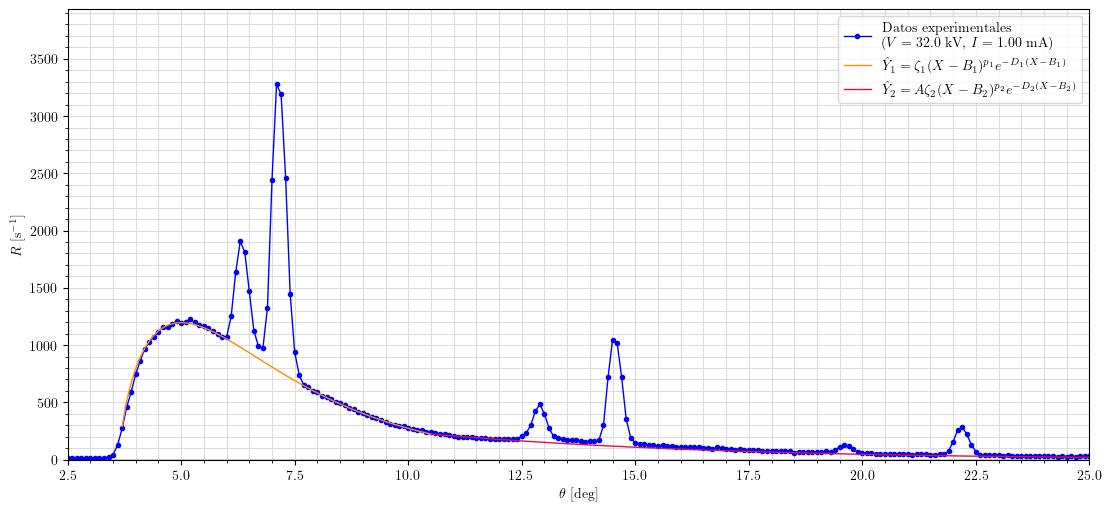

FloatSlider(value=0.7, description='p_1:', layout=Layout(width='500px'), max=3.0, step=0.015)

FloatSlider(value=3.63, description='B_1:', layout=Layout(width='500px'), max=4.0, min=3.0, step=0.005)

FloatSlider(value=0.26, description='p_2:', layout=Layout(width='500px'), max=3.0, step=0.015)

FloatSlider(value=3.63, description='B_2:', layout=Layout(width='500px'), max=4.0, min=3.0, step=0.005)

FloatSlider(value=10.52, description='θ_s:', layout=Layout(width='500px'), max=24.9, min=2.6, step=0.111499999…

In [21]:
# Gráfica del espectro continuo
plt.close('all')
%matplotlib inline

constants = ['p_1', 'B_1', 'p_2', 'B_2', 'θ_s']
sl_mins = [0, 3, 0, 3, 2.6]
sl_maxs = [3, 4, 3, 4, 24.9]
sliders_properties = zip(constants, sl_mins, sl_maxs, base_values)

sliders = []
for name, Min, Max, default_value in sliders_properties:
    slider = widgets.FloatSlider(
        value=default_value,
        min=Min,
        max=Max,
        step=(Max-Min)/200,
        description=name + ':',
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        layout=Layout(width='500px')
    )
    sliders.append(slider)
    # display(slider)

fig, ax = plt.subplots(figsize=(11, 5), layout='constrained')
ax.plot(X, Y, 'b.-', lw=1, label=lbl, zorder=2)
ax.set_xlim([X[0], X[-1]])
ax.set_ylim([0, Y.max() * 1.2])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$R$ [s$^{-1}$]')
ax.plot([2.5, 25], [0, 0], color='black', lw=1, zorder=0)

p1, B1, p2, B2, x1 = [sl.value for sl in sliders]
x0 = max(0, B1 - 2.5)
idx0 = int(x0 * 10)
idx1 = int((x1 - 2.5) * 10)
idmax = int((theta_max - 2.5) * 10)
Y_ajuste_1 = np.power(X[idx0:] - B1, p1)  * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
Y_ajuste_1 *= Y[idmax] / Y_ajuste_1[idmax - idx0]
curve_1, = ax.plot(X[idx0:idx1+1], Y_ajuste_1[:idx1-idx0+1], lw=1, c='darkorange', zorder=3, label=r'$\hat{Y}_1 = \zeta_1 (X - B_1)^{p_1} e^{- D_1 (X - B_1)}$')

Y_ajuste_2 = np.power(X[idx0:] - B2, p2)  * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))
Y_ajuste_2 *= Y[idmax] / Y_ajuste_2[idmax-idx0]
Y_ajuste_2 *= Y_ajuste_1[idx1-idx0] / Y_ajuste_2[idx1-idx0]
curve_2, = ax.plot(X[idx1:], Y_ajuste_2[idx1-idx0:], lw=1, c='crimson', zorder=3, label=r'$\hat{Y}_2 = A \zeta_2 (X - B_2)^{p_2} e^{- D_2 (X - B_2)}$')
ax.legend()
plt.show()

def update(change):
    p1, B1, p2, B2, x1 = [sl.value for sl in sliders]
    x0 = max(0, B1 - 2.5)
    idx0 = int(x0 * 10)
    idx1 = int((x1 - 2.5) * 10)
    Y_ajuste_1 = np.power(X[idx0:] - B1, p1)  * np.exp(-(p1 / (theta_max - B1)) * (X[idx0:] - B1))
    Y_ajuste_1 *= Y[idmax] / Y_ajuste_1[idmax-idx0]
    curve_1.set_data(X[idx0:idx1+1], Y_ajuste_1[:idx1-idx0+1])

    Y_ajuste_2 = np.power(X[idx0:] - B2, p2)  * np.exp(-(p2 / (theta_max - B1)) * (X[idx0:] - B2))
    Y_ajuste_2 *= Y[idmax] / Y_ajuste_2[idmax-idx0]
    Y_ajuste_2 *= Y_ajuste_1[idx1-idx0] / Y_ajuste_2[idx1-idx0]
    curve_2.set_data(X[idx1:], Y_ajuste_2[idx1-idx0:])
    fig.canvas.draw_idle()

for sl in sliders:
    display(sl)
    sl.observe(update, names='value')

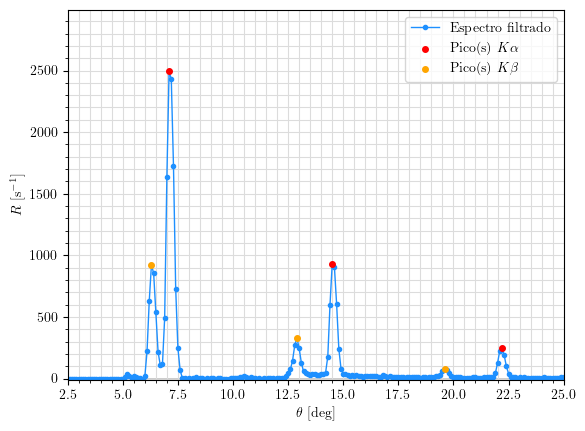

In [10]:
# Gráfica del espectro filtrado con picos
plt.close('all')
%matplotlib inline

idx_picos, _ = find_peaks(Y_fill, prominence=40)

fig, ax = plt.subplots()

ax.plot(X, Y_fill, color='dodgerblue', marker='.', label='Espectro filtrado', lw=1, zorder=2)
ax.scatter(X[idx_picos[1::2]], Y_fill[idx_picos[1::2]], s=16, color='r', zorder=3, label=r'Pico(s) $K\alpha$')
ax.scatter(X[idx_picos[::2]], Y_fill[idx_picos[::2]], s=16, color='orange', zorder=3, label=r'Pico(s) $K\beta$')
ax.plot([2.5, 25], [0, 0], color='black', lw=1, zorder=0)
ax.set_xlim([X[0], X[-1]])
ax.set_ylim([Y_fill[~np.isnan(Y_fill)].min() * 1.2, Y_fill[~np.isnan(Y_fill)].max() * 1.2])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$R$ [s$^{-1}$]')
ax.legend()
plt.show()

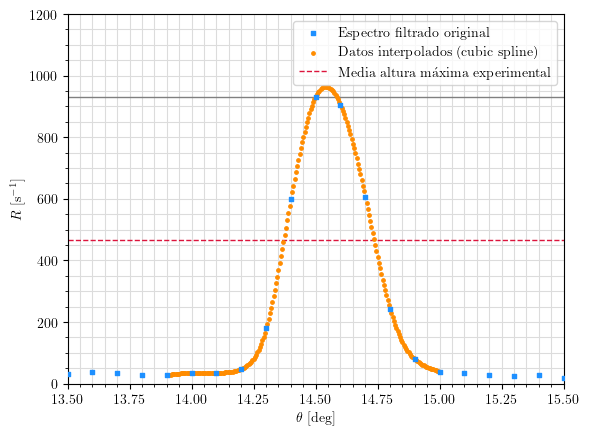

In [11]:
# Gráfica ejemplo de interpolación para la determinación del FWHM
plt.close('all')
%matplotlib inline

L, R = 120 - 13//2, 120 + 13//2
interp = interp1d(X[L:R], Y_fill[L:R], kind='cubic')
x_interp = np.arange(X[L], X[R-1], 0.005)
y_interp = interp(x_interp)

fig, ax = plt.subplots()

ax.scatter(X, Y_fill, color='dodgerblue', marker='s', s=6, label='Espectro filtrado original', zorder=4)
ax.scatter(x_interp, y_interp, color='darkorange', marker='o', s=6, label='Datos interpolados (cubic spline)', zorder=3)
ax.axhline(Y_fill[120], c='gray', lw=1, zorder=2)
ax.axhline(Y_fill[120] / 2, c='crimson', lw=1, ls='--', label='Media altura máxima experimental', zorder=2)
ax.set_xlim([13.5, 15.5])
ax.set_ylim([0, 1200])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$R$ [s$^{-1}$]')
ax.legend()
plt.show()

In [12]:
# Determinación de los picos y ancho completo a altura media (FWHM)
# Bragg
idxs, _ = find_peaks(data_Bragg['R filtrado'], prominence=40)
data_Bragg['indeces'] = np.array(idxs, dtype=np.uint16)
data_Bragg['FWHM'] = find_FWHB(data_Bragg['angle'], data_Bragg['R filtrado'], data_Bragg['indeces'], 13)
data_Bragg['indeces C'], _ = find_peaks(data_Bragg['R'][:34], prominence=40)

# Corriente de emisión
N = len(data_I_emision['I'])
indeces_list = []
FWHM_list = []
idcs_list = []
for i in range(N):
    idxs, _ = find_peaks(data_I_emision['R filtrado'][i], prominence=40)
    indeces_list.append(idxs)
    FWHM_list.append(find_FWHB(data_I_emision['angle'], data_I_emision['R filtrado'][i], idxs, 12))
    idcs_list.append(find_peaks(data_I_emision['R'][i][:34], prominence=40)[0])

data_I_emision['indeces'] = np.array(indeces_list, dtype=np.uint16)
data_I_emision['FWHM'] = np.array(FWHM_list, dtype=np.float64)
data_I_emision['indeces C'] = np.array(idcs_list, dtype=np.uint16).flatten()

In [13]:
# Ángulos encontrados para la emisión $K\alpha$ y $K\beta$ ($I$ variable)
df_I = pd.DataFrame({
    r'$I \; [\pm 0.01 \; \mathrm{mA}]$': data_I_emision['I'] * 1e3,
    r'$K\alpha \; [\mathrm{deg}]$': data_I_emision['angle'][data_I_emision['indeces'][:, 1]],
    r'$\Delta K\alpha \; [\mathrm{deg}]$': data_I_emision['FWHM'][:, 1] / 2,
    r'$K\beta \; [\mathrm{deg}]$': data_I_emision['angle'][data_I_emision['indeces'][:, 0]],
    r'$\Delta K\beta \; [\mathrm{deg}]$': data_I_emision['FWHM'][:, 0] / 2
})

df_I.index += 1
display(df_I)

,$I \; [\pm 0.01 \; \mathrm{mA}]$,$K\alpha \; [\mathrm{deg}]$,$\Delta K\alpha \; [\mathrm{deg}]$,$K\beta \; [\mathrm{deg}]$,$\Delta K\beta \; [\mathrm{deg}]$
1,0.4,7.1,0.1775,6.3,0.1750
2,0.6,7.1,0.1825,6.3,0.1800
3,0.8,7.1,0.1875,6.3,0.1775
4,1.0,7.1,0.1875,6.3,0.1800


In [14]:
# Ángulos encontrados para la emisión $K\alpha_m$ y $K\beta_m$ (Bragg, $m$ es el orden de difracción)
df_Bragg = pd.DataFrame({
    r'$K\alpha \; [\mathrm{deg}]$': data_Bragg['angle'][data_Bragg['indeces'][1::2]],
    r'$\Delta K\alpha \; [\mathrm{deg}]$': data_Bragg['FWHM'][1::2] / 2,
    r'$K\beta \; [\mathrm{deg}]$': data_Bragg['angle'][data_Bragg['indeces'][::2]],
    r'$\Delta K\beta \; [\mathrm{deg}]$': data_Bragg['FWHM'][::2] / 2
})

df_Bragg.index.name = '$m$'
df_Bragg.index += 1
display(df_Bragg)

,$K\alpha \; [\mathrm{deg}]$,$\Delta K\alpha \; [\mathrm{deg}]$,$K\beta \; [\mathrm{deg}]$,$\Delta K\beta \; [\mathrm{deg}]$
$m$,,,,
1,7.1,0.1875,6.3,0.1800
2,14.5,0.1825,12.9,0.1725
3,22.2,0.1850,19.6,0.1900


In [15]:
# Ajustes lineales del conteo de cada pico ($K\alpha$, $K\beta$ y bremsstrahlung de $I$ variable)
# Corriente de emisión
idx_Ka_I = data_I_emision['indeces'][:, 1]
idx_Kb_I = data_I_emision['indeces'][:, 0]
idx_bremss_I = data_I_emision['indeces C']

Xs = data_I_emision['I'] * 1e3

Y_Ka_I = data_I_emision['R'][:, idx_Ka_I].mean(axis=1)
Y_Kb_I = data_I_emision['R'][:, idx_Kb_I].mean(axis=1)
Y_bremss_I = data_I_emision['R continuo'][:, idx_bremss_I].mean(axis=1)

ajuste_Ka_I = OLS_regr(Xs, Y_Ka_I)
ajuste_Kb_I = OLS_regr(Xs, Y_Kb_I)
ajuste_bremss_I = OLS_regr(Xs, Y_bremss_I)

# Xs = [X_Ka_I, X_Kb_I, X_bremss_I]
Ys = [Y_Ka_I, Y_Kb_I, Y_bremss_I]
markers = ['o', 's', '^']
colors = ['r', 'orange', 'blueviolet']
colors_ajustes = ['#990000', '#996300', '#521A87']
labels = [r'$K\alpha$', r'$K\beta$', 'Bremsstrahlung']
ajustes = np.array([ajuste_Ka_I, ajuste_Kb_I, ajuste_bremss_I], dtype=np.float64)
x_lims_1 = np.array([0, 1.2])
y_lims_1 = [0, 4e3]

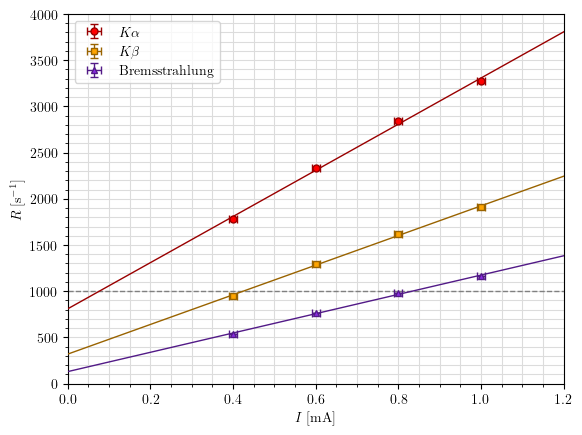

In [16]:
# Gráficas de los ajustes para $I$ variable
plt.close('all')
%matplotlib inline

fig, ax = plt.subplots()
for i in range(len(markers)):
    ax.errorbar(Xs, Ys[i], xerr=0.01, yerr=0, marker=markers[i], mfc=colors[i], ms=5,
                mec=colors_ajustes[i], label=labels[i], capsize=3, ls='', zorder=4,
                elinewidth=1, ecolor=colors_ajustes[i])
    ax.plot(x_lims_1, ajustes[i][1] + ajustes[i][0] * x_lims_1, lw=1, zorder=3, c=colors_ajustes[i])
ax.axhline(1000, color='gray', lw=1, ls='--', zorder=2)
ax.set_xlim(x_lims_1)
ax.set_ylim(y_lims_1)
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel(r'$I \; [\mathrm{mA}]$')
ax.set_ylabel(r'$R \; [\mathrm{s}^{-1}$]')
ax.legend()
plt.show()

In [17]:
# Tabla de los parámetros de cada ajuste
df = pd.DataFrame({
    'Ajuste': [r'$K\alpha$', r'$K\beta$', 'Bremsstrahlung'],
    r'$a \; [\mu \mathrm{A}^{-1} \; \mathrm{s}^{-1}]$': ajustes[:, 0] * 1e-3,
    r'$\Delta \; [\mu \mathrm{A}^{-1} \; \mathrm{s}^{-1}]$': ajustes[:, 2] * 1e-3,
    r'$b \; [\mathrm{s}^{-1}]$': ajustes[:, 1],
    r'$\Delta b \; [\mathrm{s}^{-1}]$': ajustes[:, 3],
    '$R^2$': ajustes[:, 4] ** 2
})

display(df)

,Ajuste,$a \; [\mu \mathrm{A}^{-1} \; \mathrm{s}^{-1}]$,$\Delta \; [\mu \mathrm{A}^{-1} \; \mathrm{s}^{-1}]$,$b \; [\mathrm{s}^{-1}]$,$\Delta b \; [\mathrm{s}^{-1}]$,$R^2$
0,$K\alpha$,2.498100,0.263364,808.830000,193.532520,0.997810
1,$K\beta$,1.604500,0.155522,318.800000,114.284877,0.998148
2,Bremsstrahlung,1.044726,0.084452,129.542512,62.059097,0.998711


De la ley de Bragg
$$
m \lambda = 2 d \sin \theta \qquad \left( \lambda = \frac{2 d \sin \theta}{m} \implies \Delta \lambda = \lambda \sqrt{\left(\frac{\Delta d}{d}\right)^2 + \left(\frac{\Delta \theta}{\tan \theta}\right)^2}\right)
$$

al despejar $\lambda$ de esta ecuación y reemplazando en la ecuación de la energía de un fotón ($E = h \nu = hc / \lambda$), obtenemos una expresión para la energía respecto al ángulo medido
$$
\boxed{E(\theta) = \frac{m h c}{2 d \sin \theta}}
$$

Para la propagación de errores
$$
\Delta E(\theta) = \sqrt{\left(\frac{\partial E}{\partial d} \Delta d \right)^2 + \left(\frac{\partial E}{\partial \theta} \Delta \theta \right)^2} = \frac{m h c}{2} \sqrt{\left(\frac{\Delta d}{d^2 \sin \theta}\right)^2 + \left(\frac{\cos \theta}{d \sin^2 \theta} \; \Delta \theta\right)^2},
$$

factorizando $1/(d \sin \theta)$ fuera de la raíz obtenemos:
$$
\boxed{\Delta E = E \sqrt{\left(\frac{\Delta d}{d}\right)^2 + \left(\frac{\Delta \theta}{\tan \theta}\right)^2}}
$$

In [18]:
# Constantes
# Constantes físicas
e = 1.602176634 * 1e-19  # [J/eV]
h = 6.62607015e-34       # [J s]
h_eV = h / e             # [eV s]
c = 299792458            # [m/s]

# Constantes experimentales
d = 282.01 * 1e-12      # [m]
Delta_d = 0.01 * 1e-12  # [m]

# Valores de referencia
lambda_Ka = 71.08 * 1e-12    # [m]
lambda_Kb = 63.095 * 1e-12   # [m]
E_Ka = h_eV * c / lambda_Ka  # [eV]
E_Kb = h_eV * c / lambda_Kb  # [eV]

In [19]:
# Cálculo de longitudes de onda y energías
# Corriente de emisión
raiz_Ka_I = np.sqrt((Delta_d / d) ** 2 + (np.deg2rad(df_I[r'$\Delta K\alpha \; [\mathrm{deg}]$']) / np.tan(np.deg2rad(df_I[r'$K\alpha \; [\mathrm{deg}]$']))) ** 2 )
raiz_Kb_I = np.sqrt((Delta_d / d) ** 2 + (np.deg2rad(df_I[r'$\Delta K\beta \; [\mathrm{deg}]$']) / np.tan(np.deg2rad(df_I[r'$K\beta \; [\mathrm{deg}]$']))) ** 2 )

lambda_Ka_I = 2 * d * np.sin(np.deg2rad(df_I[r'$K\alpha \; [\mathrm{deg}]$']))
Delta_lambda_Ka_I = lambda_Ka_I * raiz_Ka_I
E_Ka_I = h_eV * c / lambda_Ka_I
Delta_E_Ka_I = E_Ka_I * raiz_Ka_I

lambda_Kb_I = 2 * d * np.sin(np.deg2rad(df_I[r'$K\beta \; [\mathrm{deg}]$']))
Delta_lambda_Kb_I = lambda_Kb_I * raiz_Kb_I
E_Kb_I = h_eV * c / lambda_Kb_I
Delta_E_Kb_I = E_Kb_I * raiz_Kb_I

# Bragg
diff_m = np.array([1, 2, 3], dtype=np.uint8)
raiz_Ka_Bragg = np.sqrt((Delta_d / d) ** 2 + (np.deg2rad(df_Bragg[r'$\Delta K\alpha \; [\mathrm{deg}]$']) / np.tan(np.deg2rad(df_Bragg[r'$K\alpha \; [\mathrm{deg}]$']))) ** 2 )
raiz_Kb_Bragg = np.sqrt((Delta_d / d) ** 2 + (np.deg2rad(df_Bragg[r'$\Delta K\beta \; [\mathrm{deg}]$']) / np.tan(np.deg2rad(df_Bragg[r'$K\beta \; [\mathrm{deg}]$']))) ** 2 )

lambda_Ka_Bragg = 2 * d * np.sin(np.deg2rad(df_Bragg[r'$K\alpha \; [\mathrm{deg}]$'])) / diff_m
Delta_lambda_Ka_Bragg = lambda_Ka_Bragg * raiz_Ka_Bragg
E_Ka_Bragg = h_eV * c / lambda_Ka_Bragg
Delta_E_Ka_Bragg = E_Ka_Bragg * raiz_Ka_Bragg

lambda_Kb_Bragg = 2 * d * np.sin(np.deg2rad(df_Bragg[r'$K\beta \; [\mathrm{deg}]$'])) / diff_m
Delta_lambda_Kb_Bragg = lambda_Kb_Bragg * raiz_Kb_Bragg
E_Kb_Bragg = h_eV * c / lambda_Kb_Bragg
Delta_E_Kb_Bragg = E_Kb_Bragg * raiz_Kb_Bragg

In [20]:
# Resúmen de resultados de la parte 2
print('============= Promedios para la corriente de emisión variable ==============')
print(f'  Kα: ⟨θ⟩ = ({df_I[r'$K\alpha \; [\mathrm{deg}]$'].mean():.1f} ± {df_I[r'$\Delta K\alpha \; [\mathrm{deg}]$'].mean():.1f}) °,     ⟨λ⟩ = ({lambda_Ka_I.mean() * 1e12:.0f} ± {Delta_lambda_Ka_I.mean() * 1e12:.0f}) pm,     ⟨E⟩ = ({E_Ka_I.mean() * 1e-3:.1f} ± {Delta_E_Ka_I.mean() * 1e-3:.1f}) keV')
print(f'                               (Error = {abs(lambda_Ka_I.mean() - lambda_Ka) / lambda_Ka:.2%})           (Error = {abs(E_Ka_I.mean() - E_Ka) / E_Ka:.2%})')
print(f'  Kβ: ⟨θ⟩ = ({df_I[r'$K\beta \; [\mathrm{deg}]$'].mean():.1f} ± {df_I[r'$\Delta K\beta \; [\mathrm{deg}]$'].mean():.1f}) °,     ⟨λ⟩ = ({lambda_Kb_I.mean() * 1e12:.0f} ± {Delta_lambda_Kb_I.mean() * 1e12:.0f}) pm,     ⟨E⟩ = ({E_Kb_I.mean() * 1e-3:.1f} ± {Delta_E_Kb_I.mean() * 1e-3:.1f}) keV')
print(f'                               (Error = {abs(lambda_Kb_I.mean() - lambda_Kb) / lambda_Kb:.2%})           (Error = {abs(E_Kb_I.mean() - E_Kb) / E_Kb:.2%})')
print('============================================================================')

print('============= Promedios para los datos de la relación de Bragg =============')
print(f'              Kα: ⟨λ⟩ = ({lambda_Ka_Bragg.mean() * 1e12:.0f} ± {Delta_lambda_Ka_Bragg.mean() * 1e12:.0f}) pm,     ⟨E⟩ = ({E_Ka_Bragg.mean() * 1e-3:.1f} ± {Delta_E_Ka_Bragg.mean() * 1e-3:.1f}) keV')
print(f'                  (Error = {abs(lambda_Ka_Bragg.mean() - lambda_Ka) / lambda_Ka:.2%})           (Error = {abs(E_Ka_Bragg.mean() - E_Ka) / E_Ka:.2%})')
print(f'              Kβ: ⟨λ⟩ = ({lambda_Kb_Bragg.mean() * 1e12:.0f} ± {Delta_lambda_Kb_Bragg.mean() * 1e12:.0f}) pm,     ⟨E⟩ = ({E_Kb_Bragg.mean() * 1e-3:.1f} ± {Delta_E_Kb_Bragg.mean() * 1e-3:.1f}) keV')
print(f'                  (Error = {abs(lambda_Kb_Bragg.mean() - lambda_Kb) / lambda_Kb:.2%})           (Error = {abs(E_Kb_Bragg.mean() - E_Kb) / E_Kb:.2%})')
print('============================================================================')


============= Promedios para la corriente de emisión variable ==============
  Kα: ⟨θ⟩ = (7.1 ± 0.2) °,     ⟨λ⟩ = (70 ± 2) pm,     ⟨E⟩ = (17.8 ± 0.5) keV
                               (Error = 1.92%)           (Error = 1.96%)
  Kβ: ⟨θ⟩ = (6.3 ± 0.2) °,     ⟨λ⟩ = (62 ± 2) pm,     ⟨E⟩ = (20.0 ± 0.6) keV
                               (Error = 1.91%)           (Error = 1.94%)
============= Promedios para los datos de la relación de Bragg =============
              Kα: ⟨λ⟩ = (70 ± 1) pm,     ⟨E⟩ = (17.6 ± 0.3) keV
                  (Error = 0.88%)           (Error = 0.90%)
              Kβ: ⟨λ⟩ = (63 ± 1) pm,     ⟨E⟩ = (19.8 ± 0.3) keV
                  (Error = 0.72%)           (Error = 0.73%)
